In [11]:
import numpy as np
import numpy.random as ra
import numpy.linalg as la
from tqdm import tqdm
import matplotlib.pyplot as plt
# import os
# print(os.getcwd())

In [12]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Utils

In [70]:
def sherman_morrison(invA, u, v):
    d = u.shape[0]
    u = u.reshape(d,1)
    v = v.reshape(d,1)
    return  (invA - (invA @ u @ v.T @ invA)/(1 + v.T @ invA @ u))
    
def calc_sqrt_b_ridge(k,sigma_2,lamda,delta,S_hat,logdetG):
    '''Returns confidence interval width for ridge regression'''
    return sigma_2 * np.sqrt( logdetG - k * np.log(lamda) + np.log(1/(delta**2)) ) + np.sqrt(lamda) * S_hat 

def calc_sqrt_b_2sls(k,sigma_2,lamda,delta,S_hat,logdetG):
    '''Returns confidence interval width for 2SLS regression'''
    return sigma_2 * np.sqrt( logdetG - k * np.log(lamda) + np.log(1/(delta**2)) )

def runit(Z, X, Y, beta_star, S_hat, sigma_1, sigma_2,lamda, lamda_IV, delta, seed, pulled_indeces, algorithm='ridge'):
    '''function used to run an instance of linear bandits using OFUL with ridge or 2SLS regression'''
    np.random.seed(42)
    nb_exp, T, nb_actions, d = X.shape
    regret = np.zeros((nb_exp,T))
    pred_norms = np.zeros((nb_exp,T))
    x_inv_norms = np.zeros((nb_exp,T))
    norm_beta_hat__beta = np.zeros((nb_exp, T))
    beta_hat_rec = np.zeros((nb_exp,T,d))
    ThetaHat_rec = np.zeros((nb_exp,T, d, d))
        
    for i in tqdm(range(nb_exp)):
        
        Gxx, invGxx = lamda*np.eye(d), np.eye(d)/lamda
        Gzz, invGzz = lamda*np.eye(d), np.eye(d)/lamda # is the regularizer correct here???
        ZXt = lamda_IV*np.eye(d)
        invZXt = np.eye(d)/lamda_IV
        Zyt = np.zeros(d)
        Xyt = np.zeros(d) 

        logdetG = d*np.log(lamda)
        sqrt_b_ridge = calc_sqrt_b_ridge(d, sigma_2, lamda, delta, S_hat, logdetG)
        sqrt_b_2sls = calc_sqrt_b_2sls(d, sigma_2, lamda, delta, S_hat, logdetG)
        
        beta_hat = np.zeros(d)
        invThetaHat = np.eye(d)/lamda 


        for t in range(T):
            z = Z[i,t] ; x = X[i,t]; y = Y[i,t]


            # Make PREDICTIONS
            if algorithm == 'ridge':
                X_invGt_norm_sq = np.sum(np.dot(x, invGxx) * x, 1)
                x_inv_norms[i,t] = max(X_invGt_norm_sq)
                norm_beta_hat__beta[i,t] = np.linalg.norm(beta_hat-beta_star)
                preds = np.dot(x, beta_hat)
                pred_norms[i,t] = np.linalg.norm(preds)
                obj = preds + sqrt_b_ridge * np.sqrt(X_invGt_norm_sq) 

            if algorithm == '2sls':
                X_invThetaHat_invGt_invThetaHatT_norm_sq = np.sum((x @ invThetaHat @ invGzz @ invThetaHat.T) * x,1)
                preds = np.dot(x, beta_hat)
                norm_beta_hat__beta[i,t] = np.linalg.norm(beta_hat-beta_star)
                pred_norms[i,t] = np.linalg.norm(preds)
                obj = preds + sqrt_b_2sls * np.sqrt(X_invThetaHat_invGt_invThetaHatT_norm_sq) 


            # Pull the arm with the highest index (OPTIMISM)
            pulled_idx = np.argmax(obj)  
            pulled_indeces[i,t] = pulled_idx 
            xt = x[pulled_idx, :]
            zt = z[pulled_idx, :]
            yt = y[pulled_idx]
            # Compute REGRET
            # regret[i,t] = np.max(np.dot(x, beta_star))-np.dot(xt, beta_star) # expected regret
            regret[i,t] = np.max(y) - yt


            # build ESTIMATORS and INDECES
            if algorithm == 'ridge':
                Xyt += xt*yt
                Gxx += np.outer(xt, xt)
                if (t % 50 == 0):
                    invGxx = np.linalg.inv(Gxx)
                else:
                    invGxx = sherman_morrison(invGxx, xt,xt) 
                logdetG += xt.T @ invGxx @ xt
                sqrt_b_ridge = calc_sqrt_b_ridge(d, sigma_2, lamda, delta, S_hat, logdetG)
                beta_hat =  invGxx @ Xyt
            
            if algorithm == '2sls':
                Gxx += np.outer(xt, xt)
                Gzz += np.outer(zt, zt)  
                Zyt += zt*yt
                Xyt += xt*yt
                ZXt += np.outer(zt, xt)
                logdetG += zt.T @ invGxx @ zt
                if (t % 50 == 0): 
                    invGxx = np.linalg.inv(Gxx)
                    invZXt = np.linalg.inv(ZXt)
                    invGzz = np.linalg.inv(Gzz)
                else:
                    invGxx = sherman_morrison(invGxx, xt, xt)
                    invZXt = sherman_morrison(invZXt, zt, xt)
                    invGzz = sherman_morrison(invGzz, zt, zt) 
                ThetaHat = invGzz @ ZXt
                ThetaHat_rec[i,t, :, :] = ThetaHat 
                invThetaHat =  np.linalg.inv(ThetaHat)
                sqrt_b_2sls = calc_sqrt_b_2sls(d, sigma_2, lamda, delta, S_hat, logdetG)
                beta_hat = invZXt @ Zyt

            # record the value
            beta_hat_rec[i,t, :] = beta_hat 

    return regret, pred_norms, x_inv_norms, beta_hat_rec, ThetaHat_rec, norm_beta_hat__beta

### Experiments

In [ ]:
S, sigma_1, sigma_2 = 1, 0.01, 0.0001
nb_exp, T, n_a, d = 100, int(1e3), 100, 20

theta_star = np.random.randn(d,d); #  theta_star *= 1/np.linalg.norm(theta_star) #maybe this can be changed
inv_theta_star = np.linalg.inv(theta_star)
beta_star = np.random.multivariate_normal([10 for i in range(d)], np.eye(d)).reshape(-1,) ; beta_star *= S/np.linalg.norm(beta_star)

lamda = 1 ; lamda_IV = 1e-3
delta = 0.001
seed = 1996
S_hat = S
pulled_indeces = np.zeros((nb_exp,T))


In [ ]:
# first stage
# X_max = 100
Z = np.random.randn(nb_exp, T, n_a, d) #; Z /= np.max(np.linalg.norm(Z,axis=2))/X_max
eps = sigma_1*np.random.randn(nb_exp, T, n_a, d)
# eps = np.zeros((T,d))
X = np.dot(Z, theta_star) + eps

# second stage
ee = d//4
eta_tilde = np.random.randn(nb_exp, T, n_a) 
# eta = (eta_tilde + np.sum(eps[:,:,:,:ee]))/(1+ee*sigma_1)*sigma_2
eta = sigma_2 * (eta_tilde + eps[:,:,:,:ee].sum(axis=-1))
X = X / np.max(np.linalg.norm(X, axis=3, keepdims = True), axis=2, keepdims=True) 
Y = np.dot(X, beta_star) + eta

In [ ]:
algorithms = ['ridge','2sls']
labels = ['OFUL$^{r}$','OFUL$^{f}$']
# colors = ['blue','darkviolet','darkorange']#,'darkred']
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
# s_colors = ['cyan','violet','orange']#,'red']

In [71]:
regrets = np.zeros((nb_exp,len(algorithms),T))
pred_norms = np.zeros((nb_exp,len(algorithms),T))
x_inv_norms = np.zeros((nb_exp,len(algorithms),T))
# beta_hat_ridge = np.zeros((nb_exp,T,d))
beta_hat = np.zeros((nb_exp, len(algorithms), T,d))
theta_hat = np.zeros((nb_exp, len(algorithms), T, d, d))
beta_error = np.zeros((nb_exp, len(algorithms), T))

for i,a in enumerate(algorithms):
    regrets[:,i,:], pred_norms[:,i,:], x_inv_norms[:,i,:],\
         beta_hat[:, i, :,:] , theta_hat[:, i, :,:, :], beta_error[:,i,:]\
             = runit(Z, X, Y, beta_star, S_hat, sigma_1, sigma_2, lamda, lamda_IV, delta, seed, pulled_indeces, a)

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [72]:
# print("||beta - beta|| = ", np.linalg.norm((beta_star-beta_star).mean(axis=0)))
print("||betaHat_ridge - beta|| = ", np.linalg.norm((beta_hat[:, 0, -1, :]-beta_star).mean(axis=0)))
print("||betaHat_IV - beta|| = ", np.linalg.norm((beta_hat[:, 1, -1, :]-beta_star).mean(axis=0)))

# print(np.linalg.norm((theta_star - np.array([0.]))))
# print(np.linalg.norm((theta_hat[:, 0, -1, :, :]-theta_star).mean(axis=0)))
print("||thetaHat - theta|| = ", np.linalg.norm((theta_hat[:, 1, -1, :, :]-theta_star).mean(axis=0)))

# mean_beta_ridge = beta_hat[:, 0, -1, :].mean(axis=0)
# mean_beta_2sls = beta_hat[:, 1, -1, :].mean(axis=0)
# print(beta_star) 
# print(mean_beta_ridge) 
# print(mean_beta_2sls)

||betaHat_ridge - beta|| =  0.24296810243369588
||betaHat_IV - beta|| =  4.203925001859993e-05
||thetaHat - theta|| =  18.556375858035157


In [73]:
pulled_indeces

array([[91., 91., 95., ..., 63., 72., 98.],
       [33., 45., 56., ..., 13., 57., 15.],
       [60., 55., 12., ..., 75., 91., 85.],
       ...,
       [78., 58., 97., ..., 51., 12., 13.],
       [86., 87., 94., ..., 85., 13., 44.],
       [86., 83., 16., ..., 36.,  8., 75.]])

### Regret

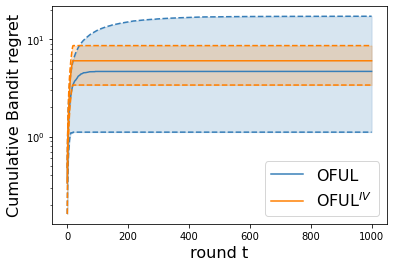

<Figure size 432x288 with 0 Axes>

In [74]:
mean_regret = np.cumsum(regrets.mean(axis=0),axis=1)
std_regret = np.cumsum(regrets.std(axis=0),axis=1)


fst_quantile_regret = np.cumsum(np.quantile(regrets,0.25,axis=0),axis=1)
scd_quantile_regret = np.cumsum(np.quantile(regrets,0.5,axis=0),axis=1)
thd_quantile_regret = np.cumsum(np.quantile(regrets,0.75,axis=0),axis=1)
# _ = np.log(lamda+(X_max**2)*np.arange(1,T+1)/d)

labels = ['OFUL','OFUL$^{IV}$']

for i,a in enumerate(algorithms):
#     plt.plot(np.divide(mean_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),label=labels[i],color=colors[i])
    # plt.plot(mean_regret[i],label=labels[i],color=colors[i])
#     plt.fill_between(np.arange(T),np.divide(fst_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),np.divide(thd_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),color=colors[i],alpha=0.2)
    plt.fill_between(np.arange(T),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_regret[i],color=colors[i],linestyle="solid", label = labels[i])
    plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
    # plt.fill_between(np.arange(T),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.1)
# log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("round t")
plt.ylabel('Cumulative Bandit regret')
# plt.xlim([0,50])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.show()
plt.savefig("cumulative_regret.pdf", format='pdf')

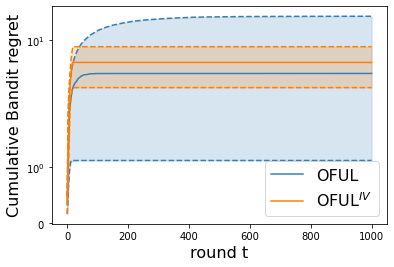

<Figure size 432x288 with 0 Axes>

In [75]:
start = 0
mean_regret = np.cumsum(regrets.mean(axis=0)[:,start:] ,axis=1)
std_regret = np.cumsum(regrets.std(axis=0)[:,start:],axis=1)

fst_quantile_regret = np.cumsum(np.quantile(regrets[:,:,start:],0.25,axis=0),axis=1)
scd_quantile_regret = np.cumsum(np.quantile(regrets[:,:,start:],0.5,axis=0),axis=1)
thd_quantile_regret = np.cumsum(np.quantile(regrets[:,:,start:],0.75,axis=0),axis=1)

labels = ['OFUL','OFUL$^{IV}$']

for i,a in enumerate(algorithms):
#     plt.plot(np.divide(mean_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),label=labels[i],color=colors[i])
    # plt.plot(mean_regret[i],label=labels[i],color=colors[i])
    # plt.fill_between(np.arange(T-start),np.divide(fst_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),np.divide(thd_quantile_regret[i],np.sqrt(T*d*_*np.arange(1,T+1))),color=colors[i],alpha=0.2)
    plt.fill_between(np.arange(T-start),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    plt.plot(scd_quantile_regret[i],color=colors[i],linestyle="solid", label = labels[i])
    plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
    # plt.fill_between(np.arange(T-start),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.1)
# log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('symlog')
plt.xlabel("round t")
plt.ylabel('Cumulative Bandit regret')
# plt.xlim([0,50])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.show()
plt.savefig("cumulative_regret_warm_start.pdf", format='pdf')

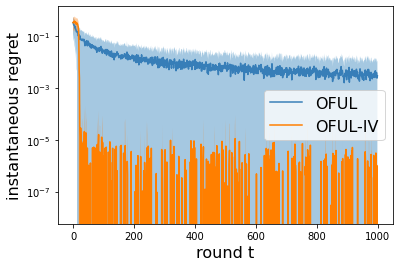

In [76]:
mean_regret = regrets.mean(axis=0)
std_regret = regrets.std(axis=0)


fst_quantile_regret = np.quantile(regrets,0.25,axis=0)
scd_quantile_regret = np.quantile(regrets,0.5,axis=0)
thd_quantile_regret = np.quantile(regrets,0.75,axis=0)
# _ = np.log(lamda+(X_max**2)*np.arange(1,T+1)/d)

labels = ['OFUL','OFUL-IV']

for i,a in enumerate(algorithms):
    plt.plot(mean_regret[i],label=labels[i],color=colors[i])
    plt.fill_between(np.arange(T),mean_regret[i]-std_regret[i],mean_regret[i]+std_regret[i],alpha=0.4)

    # plt.fill_between(np.arange(T),fst_quantile_regret[i],thd_quantile_regret[i],color=colors[i],alpha=0.2)
    # plt.plot(fst_quantile_regret[i],color=colors[i],linestyle="dashed")
    # plt.plot(scd_quantile_regret[i],color=colors[i],linestyle="solid", label = labels[i])
    # plt.plot(thd_quantile_regret[i],color=colors[i],linestyle="dashed")
# log_ = np.log(lamda+np.arange(1,T+1)/d)
# plt.plot(4*np.sqrt(T*d*log_)*(np.sqrt(lamda)*S_hat+sigma*np.sqrt(2*np.log(1/delta)+d*(log_-np.log(lamda)))),label="bound",linestyle="dashed")
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("round t")
plt.ylabel('instantaneous regret')
# plt.xlim([0,50])
# plt.plot(np.cumsum(regret[:,1,:].mean(axis=0)),label='forward')
# plt.plot(np.cumsum(regret,axis=1).std(axis=0))
plt.legend()
plt.savefig("B_instantaneous_regret.pdf", format='pdf')

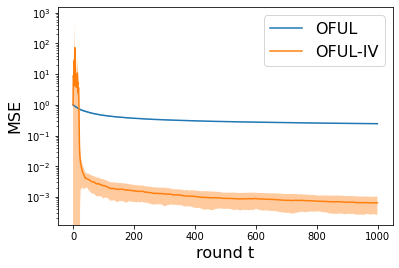

In [77]:
mean_beta_errors = beta_error.mean(axis=0)
std_beta_errors = beta_error.std(axis=0)

fst_quantile_beta_error = np.quantile(beta_error,0.25,axis=0)
scd_quantile_beta_error = np.quantile(beta_error,0.5,axis=0)
thd_quantile_beta_error = np.quantile(beta_error,0.75,axis=0)

labels = ['OFUL','OFUL-IV']
for i,a in enumerate(algorithms):
    plt.plot(mean_beta_errors[i,:], label= labels[i])
    plt.fill_between(np.arange(T),mean_beta_errors[i]-std_beta_errors[i],mean_beta_errors[i]+std_beta_errors[i],alpha=0.4)

    # plt.fill_between(np.arange(T),fst_quantile_beta_error[i],thd_quantile_beta_error[i],color=colors[i],alpha=0.2)
    # plt.plot(fst_quantile_beta_error[i],color=colors[i],linestyle="dashed")
    # plt.plot(scd_quantile_beta_error[i],color=colors[i],linestyle="solid", label = labels[i])
    # plt.plot(thd_quantile_beta_error[i],color=colors[i],linestyle="dashed")
plt.legend()
plt.xlabel("round t")
plt.ylabel('MSE')
plt.yscale("log")
plt.savefig("B_beta_error.pdf", format='pdf')